In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from itertools import cycle, islice

import warnings
warnings.filterwarnings("ignore")

# Импорт данных и предобработка

In [2]:
df = pd.read_table('car.data', sep= ',', names= ['buying_price','maint_price','doors','persons','lug_boot','safety','acceptability'])
df.head()

,buying_price,maint_price,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


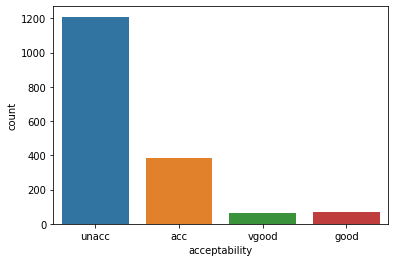

In [3]:
sns.countplot(x='acceptability',data=df)

Наблюденя разделены на 4 класса - это число и будем использовать в качестве параметра k-means

In [4]:
df.describe()

,buying_price,maint_price,doors,persons,lug_boot,safety,acceptability
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,high,high,2,2,big,high,unacc
freq,432,432,432,576,576,576,1210


Как мы видим - все фичи категориальные. Перекодируем и заодно отложим отдельно целевую фичу (на всякий случай)

In [5]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
X = pd.DataFrame(df[df.drop('acceptability',axis=1).columns].
                 apply(lambda x: d[x.name].fit_transform(x)).values,
                 columns=df.drop('acceptability',axis=1).columns)
y = df[['acceptability']].values

# Пробное обучение и визуализация

Попробуем сначала взять пару фич из датасета, обучим на них модель с фиксированным параметром k = 4 и визуализируем

In [6]:
X_mod = X[['buying_price','safety']]
km = KMeans(n_clusters=4)
km.fit(X_mod)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0, 0.5, 'safety')

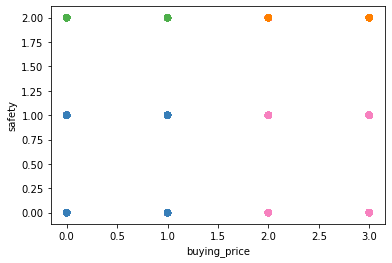

In [7]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf',
                                     '#a65628', '#984ea3', '#999999', '#e41a1c']),
                                      int(max(km.labels_) + 1))))
plt.scatter(X['buying_price'], X['safety'], color = colors[km.labels_])
plt.xlabel('buying_price')
plt.ylabel('safety')

# Подбор параметра k

Теперь поподбираем параметр k уже при обучении на всех фичах. Визуализируем инерцию и силуэт

Text(0, 0.5, 'Инерция')

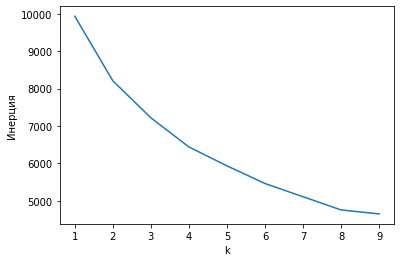

In [8]:
inertia = []
k_range = range(1, 10)
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia)
plt.xlabel('k')
plt.ylabel('Инерция')

Text(0, 0.5, 'Силуэт')

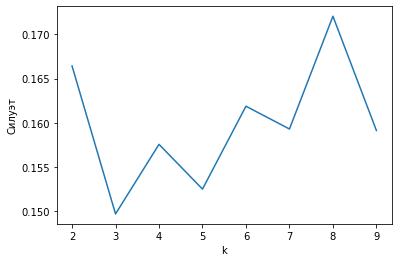

In [9]:
from sklearn.metrics import silhouette_score

silhouette = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    silhouette.append(silhouette_score(X, km.labels_))

plt.plot(k_range, silhouette)
plt.xlabel('k')
plt.ylabel('Силуэт')

Очевидно, что на датасете, состоящем только из категориальных переменных, алгоритм будет иметь максимальное качество при k = количеству комбинаций категорий, поскольку точки распределены равномерно на пересечениях целых значений - кодов категорий

Поэтому попробуем взять другой датасет

# Другой датасет

In [10]:
df = pd.read_table('data_banknote_authentication.txt', sep= ',', names= ['variance','skewness','curtosis','entropy','class'])
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


Датасет представляет из себя результаты графического анализа подлинных и поддельных банкнот (целевая переменная class). В ходе анализа были получены 4 предиктора - различные характеристики изображения 

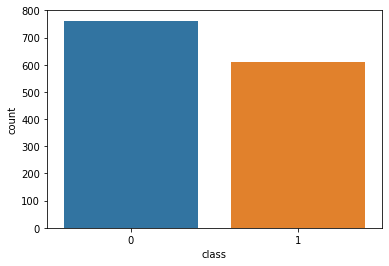

In [11]:
sns.countplot(x='class',data=df)

Выкинем сразу целевую переменную (но держим в голове, что изначально подразумевалось 2 класса)

In [12]:
df.drop(df[['class']], axis=1, inplace=True)
df

,variance,skewness,curtosis,entropy
0,3.62160,8.66610,-2.8073,-0.44699
1,4.54590,8.16740,-2.4586,-1.46210
2,3.86600,-2.63830,1.9242,0.10645
3,3.45660,9.52280,-4.0112,-3.59440
4,0.32924,-4.45520,4.5718,-0.98880
...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949
1368,-1.38870,-4.87730,6.4774,0.34179
1369,-3.75030,-13.45860,17.5932,-2.77710
1370,-3.56370,-8.38270,12.3930,-1.28230


In [13]:
df.describe()

,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


In [14]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns=['variance','skewness','curtosis','entropy'])

Также сначала попробуем визуализировать разбиение  

In [15]:
X_mod = df[['variance','skewness']]
km = KMeans(n_clusters=2)
km.fit(X_mod)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0, 0.5, 'skewness')

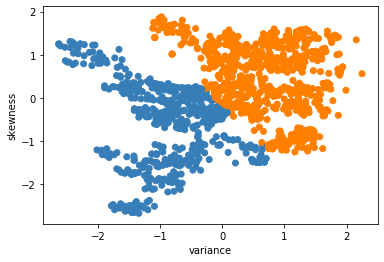

In [16]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf',
                                     '#a65628', '#984ea3', '#999999', '#e41a1c']),
                                      int(max(km.labels_) + 1))))
plt.scatter(X_mod['variance'], X_mod['skewness'], color = colors[km.labels_])
plt.xlabel('variance')
plt.ylabel('skewness')

И подберём параметр k

In [17]:
inertia = []
silhouette = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(df)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(df, km.labels_))

Text(0, 0.5, 'Инерция')

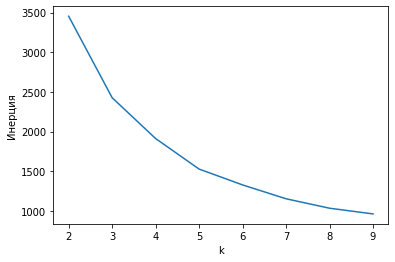

In [18]:
plt.plot(k_range, inertia)
plt.xlabel('k')
plt.ylabel('Инерция')

Text(0, 0.5, 'Силуэт')

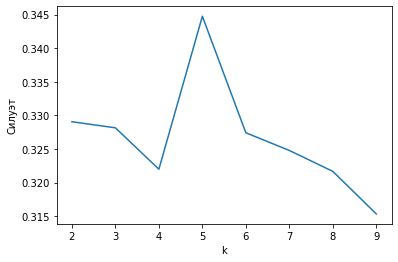

In [19]:
plt.plot(k_range, silhouette)
plt.xlabel('k')
plt.ylabel('Силуэт')

Алгоритм сообщает, что оптимальное количество кластеров = 5